In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import regularizers
import h5py
import io
import os
import sagemaker
import boto3
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
bucket_name = 'demo-saeed'
bucket_path="s3://" + bucket_name + "/"
prefix = 'fraudcredit-est'

training_set_path = bucket_path + prefix + "/train/"
test_set_path = bucket_path + prefix + "/test/"

In [3]:
df = pd.read_csv(bucket_path + prefix + '/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


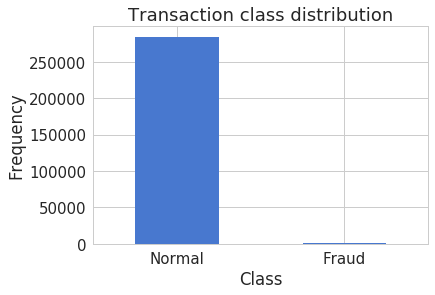

In [4]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']                                               
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))
                                               
train_file = 'train_data.csv'                          
pd.concat([ X_train,y_train], axis=1).to_csv(train_file, index=False, header=False)                                               
test_file = 'test_data.csv'                          
pd.concat([ X_test,y_test], axis=1).to_csv(test_file, index=False, header=False)  



Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


In [6]:
pd.read_csv(train_file).head()

,-0.13206625955969098,0.10704355070308501,-0.65058817298528,-0.996032267975816,1.81433323189868,1.74074026929169,0.49685179480457997,0.633015903753692,0.0171809432787972,-0.36270733923285103,...,-0.062488647130764005,0.005292411640286879,0.25151860625716393,-2.46681020740765,-0.889690373413264,0.337462474217117,0.306394657332192,0.0748169663405004,-0.16176104513913486,0
0,2.125994,0.014207,-1.514760,0.115021,0.598510,-0.333235,0.199289,-0.264353,0.384111,0.028747,...,-0.329368,-0.788150,0.267730,0.066122,-0.135785,0.203841,-0.068267,-0.057678,-0.345313,0
1,-0.086694,0.166240,1.573127,0.687266,0.222359,1.102606,1.575093,-1.098608,0.763887,1.404677,...,0.015324,1.063663,-0.410841,0.722723,-0.171733,-0.613543,-1.201571,-1.139931,0.326845,0
2,1.352339,-0.534984,0.555143,-0.629355,-1.144170,-0.852967,-0.642128,-0.032659,-0.654482,0.619206,...,-0.014814,-0.180379,0.178112,0.347720,0.151810,-0.404361,0.013746,0.016152,-0.329401,0
3,-1.526760,0.647782,0.615391,-0.561114,0.836950,-0.514251,0.984325,-0.097430,-0.062634,-1.033567,...,-0.221533,-0.393158,-0.214990,0.588447,0.679496,0.518434,0.065022,0.147294,0.006398,0
4,-1.249955,1.479912,1.105997,-0.197960,-0.013768,-1.060248,0.921704,-0.398320,1.042471,1.322536,...,-0.517503,-0.874559,0.062009,0.263798,-0.062675,0.033014,0.217892,-0.116049,-0.342475,0


In [7]:

boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/'+train_file)).upload_file(train_file)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/'+test_file)).upload_file(test_file)


## Initialize variables and execution roles

In [8]:
from sagemaker import get_execution_role

#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = bucket_path + prefix + '/scripts'

#Bucket location where results of model training are saved.
model_artifacts_location = bucket_path + prefix +'/artifacts'

#IAM execution role that gives SageMaker access to resources in your AWS account.
role = get_execution_role()

In [9]:
!cat "dnn_classifier.py"

import numpy as np
import os
import tensorflow as tf

INPUT_TENSOR_NAME = 'inputs'


def estimator_fn(run_config, params):
    feature_columns = [tf.feature_column.numeric_column(INPUT_TENSOR_NAME, shape=[29])]
    return tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                      hidden_units=[10, 20, 10],
                                      n_classes=2,
                                      config=run_config)


def serving_input_fn(params):
    feature_spec = {INPUT_TENSOR_NAME: tf.FixedLenFeature(dtype=tf.float32, shape=[29])}
    return tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)()


def train_input_fn(training_dir, params):
    """Returns input function that would feed the model during training"""
    return _generate_input_fn(training_dir, 'train_data.csv')


def eval_input_fn(training_dir, params):
    """Returns input function that would feed the model during evaluation"""
    return _generate_input_fn(traini

In [10]:
from sagemaker.tensorflow import TensorFlow

my_estimator = TensorFlow(entry_point = 'dnn_classifier.py',
                            role=role,
                            output_path = model_artifacts_location,
                            code_location = custom_code_upload_location,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            training_steps=1000,
                            evaluation_steps=100)

No framework_version specified, defaulting to version 1.11. This is not the latest supported version. If you would like to use version 1.15, please add framework_version=1.15 to your constructor.
tensorflow py2 container will be deprecated soon.


In [11]:
%%time
import boto3

# use the region-specific sample data bucket
region = boto3.Session().region_name
train_data_location = bucket_path + prefix +'/train/'.format(region)

print(train_data_location)

s3://demo-saeed/fraudcredit-est/train/
CPU times: user 16.4 ms, sys: 136 µs, total: 16.6 ms
Wall time: 16 ms


In [12]:
train_data_location

's3://demo-saeed/fraudcredit-est/train/'

In [13]:
my_estimator.fit(train_data_location)

2020-02-04 19:07:43 Starting - Starting the training job...
2020-02-04 19:07:46 Starting - Launching requested ML instances......
2020-02-04 19:08:50 Starting - Preparing the instances for training......
2020-02-04 19:10:14 Downloading - Downloading input data
2020-02-04 19:10:14 Training - Downloading the training image...
2020-02-04 19:10:33 Training - Training image download completed. Training in progress.2020-02-04 19:10:33,521 INFO - root - running container entrypoint
2020-02-04 19:10:33,521 INFO - root - starting train task
2020-02-04 19:10:33,534 INFO - container_support.training - Training starting
2020-02-04 19:10:36,320 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2020-02-04 19:10:36,320 INFO - tf_container - {"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2020-02-04 19:10:36,320 INFO - tf_container - ---------------------------------------------------------
2020-02-04 19:10:36,320 I

In [43]:
%%time
my_predictor = my_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-2019-04-30-15-33-34-177
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-2019-04-30-15-33-34-177


----------------------------------------------------------------------------!CPU times: user 399 ms, sys: 15.3 ms, total: 415 ms
Wall time: 6min 25s


In [44]:
my_predictor.predict([-15.819178720771802,8.7759971528627,-22.8046864614815,11.864868080360699,-9.09236053189517,-2.38689320657655,-16.5603681078199,0.9483485947860579,-6.31065843275059,-13.0888909176936,9.81570317447819,-14.0560611837648,0.777191846436601,-13.7610179615936,-0.353635939812489,-7.9574472262599505,-11.9629542349435,-4.7805077876172,0.652498045264831,0.992278949261366,-2.35063374523783,1.03636187430048,1.13605073696052,-1.0434137405139001,-0.10892334328197999,0.657436778462222,2.1364244708551396,-1.41194537483904,-0.3492313067728856]) #expected label to be 1

{'result': {'classifications': [{'classes': [{'label': '0',
      'score': 0.004524214658886194},
     {'label': '1', 'score': 0.9954758286476135}]}]},
 'model_spec': {'name': 'generic_model',
  'version': {'value': 1556638579},
  'signature_name': 'serving_default'}}

In [45]:
my_predictor.endpoint

'sagemaker-tensorflow-2019-04-30-15-33-34-177'